In [1]:
import os
from time import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from dataset_coroutine import dataset_coroutine

#odc = dataset_coroutine(
#    links_list=['/home/jupyter/datasphere/s3/garbage-data/generated-data/generated_roman_last_version'],
#    default_names=['image.jpeg'] + [f'class_{i}.png' for i in range(6)],
#    image_types=['image'] + ['mask'] * 6,
#    each_n=1500,
#    total_n=np.inf
#)

In [3]:
from assign_labels import load_reducer
reducer = load_reducer()

2024-04-20 11:26:06.680256: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-20 11:26:06.722290: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-20 11:26:07.415888: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [84]:
batch_size = 5000
datasets_path='/home/jupyter/datasphere/s3/garbage-data/stargan_datasets'
dataset_name = 'generated_image_with_mask_dataset'
stargan_dataset_path = os.path.join(datasets_path, dataset_name)

In [164]:
from generate_stargan_dataset import make_stargandataset_dir

make_stargandataset_dir(datasets_path=datasets_path, name=dataset_name, del_prev=False)

In [87]:
#image_and_masks[:, :, 3:] = np.where(image_and_masks[:, :, 3:] > th, 255, 0)

2


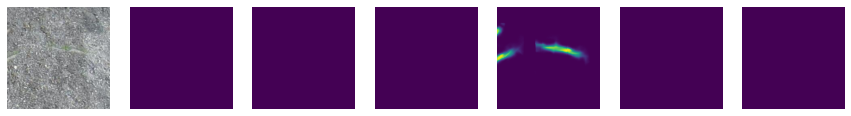

odc_number:  2
total_number:  2


In [79]:
image_and_masks = next(odc)
image_and_masks = handler(image_and_masks)


for image_and_masks in odc:
    fig, axes = plt.subplots(ncols=7, figsize=(15, 3))

    image_and_masks = handler(image_and_masks)
    for i in range(len(axes)):
        if i == 0:
            img = image_and_masks[:, :, :3]
        else:
            img = image_and_masks[:, :, 2 + i]
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.show()

In [132]:
import numpy as np

def get_img_hist(img, mask=None, bins=256):
    if mask is not None:
        img = img[mask]
        
    img = img.reshape(-1, 3)

    r_hist = np.histogram(img[:, 0], bins=np.arange(0, 256, 1), density=True)[0]
    g_hist = np.histogram(img[:, 1], bins=np.arange(0, 256, 1), density=True)[0]
    b_hist = np.histogram(img[:, 2], bins=np.arange(0, 256, 1), density=True)[0]

    return np.concatenate([r_hist, g_hist, b_hist]) / 3


def get_color_histograms_of_images(crops_batch, masks_batch=None, with_images=False):
    hists = []

    if masks_batch is not None:
        for i, (crop, mask) in enumerate(zip(crops_batch, masks_batch)):
            hists.append(get_img_hist(crop, mask))
    else:
        for i, crop in enumerate(crops_batch):
            hists.append(get_img_hist(crop))

    hists = np.array(hists)
    if with_images:
        imgs = np.concatenate([img[None] for img in imgs], axis=0)
        return hists, imgs
    else:
        return hists


def color_hist_to_2d(hists, reducer):
    umap_hists = reducer.transform(hists).T
    umap_hists[1] *= -1
    return umap_hists

In [162]:
from assign_labels import assign_labels

def get_common_mask(masks, th=100):
    masks = np.where(masks > th, 255, 0)
    common_mask = np.max(masks, axis=-1)
    return common_mask > 0


def handler(image_and_masks):
    image_and_masks = [
        img[:, :, None] if len(img.shape) == 2 else img 
        for img in image_and_masks
    ]

    image_and_masks = np.concatenate(image_and_masks, axis=-1)
    return image_and_masks


def save_batch(batch, numbers, labels, dataset_path, 
               name_pattern='000000', class_pattern='class_00'):
    for img, numb, lab in zip(batch, numbers, labels):
        numb = f'{numb}'
        name = name_pattern[:-len(numb)] + numb
        
        class_name = str(lab)
        class_name = class_pattern[:-len(class_name)] + class_name
        img_path = os.path.join(dataset_path, class_name, f'{name}')
        np.save(img_path, img)


def generate_stargan_dataset(reducer, dataset_coroutine, handler, batch_size, stargan_dataset_path):
    images_batch = []
    masks_batch = []
    batch = []

    img_numbers = []
    current_img = 1
    while True:
        try:
            t1 = time()
            for i in range(batch_size):
                image_and_masks = handler(next(dataset_coroutine))

                image = image_and_masks[:, :, :3]
                common_mask = get_common_mask(image_and_masks[:, :, 3:])

                images_batch.append(image)
                masks_batch.append(~common_mask)
                batch.append(image_and_masks)

                img_numbers.append(current_img)
                current_img += 1

            batch_hists = get_color_histograms_of_images(images_batch, masks_batch)
            batch_umap_hists = color_hist_to_2d(batch_hists, reducer)
            labels = assign_labels(batch_umap_hists)

            save_batch(batch, img_numbers, labels, stargan_dataset_path)
            t2 = time()
            print(f'{current_img} images was saved: {round(t2 - t1)}s')

            images_batch = []
            masks_batch = []
            batch = []
            img_numbers = []
        except StopIteration:
            break

    return current_img

In [165]:
odc = dataset_coroutine(
    links_list=['./check_dataset/'],
    default_names=['image.jpeg'] + [f'class_{i}.png' for i in range(6)],
    image_types=['image'] + ['mask'] * 6,
    each_n=10,
    total_n=np.inf
)

generate_stargan_dataset(reducer, odc, handler, 2, stargan_dataset_path)

10
3 images was saved: 2s
5 images was saved: 2s
7 images was saved: 1s
9 images was saved: 2s
11 images was saved: 2s
odc_number:  10
total_number:  10


11

In [167]:
#!ls /home/jupyter/datasphere/s3/garbage-data/stargan_datasets/generated_image_with_mask_dataset/class_09